#*FASE 0:* Analisi agente e ambiente

L'agente di "anomaly detection" è un sistema informatico sviluppato per identificare comportamenti, dati o eventi insoliti che deviano da quelli ritenuti normali in specifici contesti.

Le carattestiche di un'agente di anomaly detection sono:


*   *Capacità di apprendimento:* l'agente utilizza tecniche di machine learning e data mining per apprendere dalla normalità dei dati storici. Questo può includere algoritmi di clustering, classificazione o reti neurali.
*   *Sensibilità ai cambiamenti:* è progettato per essere altamente sensibile ai piccoli cambiamenti nei dati, cosa essenziale per rilevare tempesticamente le anomalie.
*   *Adattabilità:* ha la capacità di adattarsi nel tempo alle nuove normalità, cosa cruciale in ambienti dinamici dove i pattern di dati possono evolversi.
*   *Automazione:*  Opera in modo autonomo per segnalare anomalie senza la necessità di un intervento umano costante, permettendo risparmio di tempo e risorse.



Le caratteristiche dell'ambiente in cui opera sono:

*   *Ambiente dinamico:* in questo caso, l'agente opera in un'ambiente che cambia mentre l'agente sta decidendo come agire.
*   *Grande volume dei dati:* l'ambiente tipicamente gestisce enormi quantità di dati. L'agente deve essere in grado di processare e analizzare i dati in tempo reale o in batch, a seconda delle necessità.
*   *Variabilità dei dati:* l'ambiente può avere dati provenienti da diverse fonti e di diversi tipi (numerici, categorici, testuali, etc.) che richiedono metodologie di preelaborazione specifiche.
*   *Requisiti di velocità:* in contesti come l'analisi delle anomalie nelle folle, la rapidità nella rilevazione delle anomalie è cruciale per evitare e/o limitare i danni.
*   *Privacy e sicurezza:* gli ambienti che trattano dati sensibili richiedono che l'agente mantenga elevati standard di sicurezza e conformità alle normative sulla privacy dei dati.



#*FASE 1:* Preparazione e analisi dei dati

##1.1 - Importazione delle librerie

In [ ]:
from pydrive2.auth import GoogleAuth
from pydrive2.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import os
import pickle
import cv2
import numpy as np
import h5py
from IPython.display import HTML, display
from sklearn.decomposition import IncrementalPCA
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
#modello LSTM
import shutil
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

##1.2 - Caricamento del dataset

In [ ]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

downloaded = drive.CreateFile({'id': '18xwgyRJGx_DHPW3n0RuH7N28Z_icf9wg'})
downloaded.GetContentFile('dataset_progettoIAS.zip')
!unzip dataset_progettoIAS
print('Done! Run the BSIF Filters download code.')

Archive:  dataset_progettoIAS.zip
   creating: anomaly/
  inflating: anomaly/001_label_4.mp4  
  inflating: anomaly/002_label_4.mp4  
  inflating: anomaly/003_label_4.mp4  
  inflating: anomaly/004_label_4.mp4  
  inflating: anomaly/005_label_4.mp4  
  inflating: anomaly/006_label_4.mp4  
  inflating: anomaly/007_label_4.mp4  
  inflating: anomaly/008_label_4.mp4  
  inflating: anomaly/009_label_4.mp4  
  inflating: anomaly/010_label_4.mp4  
  inflating: anomaly/011_label_4.mp4  
  inflating: anomaly/012_label_1.mp4  
  inflating: anomaly/013_label_1.mp4  
  inflating: anomaly/014_label_1.mp4  
  inflating: anomaly/015_label_1.mp4  
  inflating: anomaly/016_label_1.mp4  
  inflating: anomaly/017_label_1.mp4  
  inflating: anomaly/025_label_1.mp4  
  inflating: anomaly/026_label_1.mp4  
  inflating: anomaly/027_label_1.mp4  
  inflating: anomaly/027_label_4.mp4  
  inflating: anomaly/030_label_1.mp4  
  inflating: anomaly/031_label_1.mp4  
  inflating: anomaly/desktop.ini     
   creati

In [ ]:
#mount del drive per caricare i dati salvati
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##1.3 - Analisi preliminare del dataset

In [ ]:
dataset_path = '/content'

num_campioni_normal = len(os.listdir(os.path.join(dataset_path, 'normal')))
num_campioni_anomaly = len(os.listdir(os.path.join(dataset_path, 'anomaly')))

print("Campioni normali: ", num_campioni_normal)
print("Campioni con anomalie: ", num_campioni_anomaly)

Campioni normali:  30
Campioni con anomalie:  24


##1.4 - Estrazione dei frames

###1.4.1 - Definizione della funzione che va a estrarre i frame dal video *.mp4* e li raggruppa in un vettore

La funzione inoltre ci permette di selezionare quanti fps vogliamo mantenere per ottimizzare il costo computazionale

In [ ]:
#fps = numero di frame al secondo che si vogliono far leggere
def load_data(directory, fps):
    frames = []

    # Scorrere ogni file nella directory principale
    for file_name in os.listdir(directory):
        file_path = os.path.join(directory, file_name)  # Percorso del file

        # Caricare i frame se il file è un video MP4
        if file_path.endswith(".mp4"):
            video = cv2.VideoCapture(file_path)
            video_fps = video.get(cv2.CAP_PROP_FPS)  # FPS del video
            frame_skip = round(video_fps / fps)  # Calcola ogni quanti frame leggere

            frame_index = 0
            while True:
                success, frame = video.read()
                if not success:
                    break

                # Leggi un frame ogni 'frame_skip' frame
                if frame_index % frame_skip == 0:
                    frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
                    frames.append(frame_gray)

                frame_index += 1

            video.release()

    print("Number of frames:", len(frames))
    return frames


###1.4.2 - Estrazione dei frames e visualizzazione, sia per il dataset *normal* che *anomaly*

In [ ]:
frames_normal = load_data('/content/normal', 6 ) # Vengono presi 6 frames al secondo

Number of frames: 1762


array([[2, 2, 2, ..., 0, 0, 0],
       [2, 2, 2, ..., 0, 0, 0],
       [2, 2, 2, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)
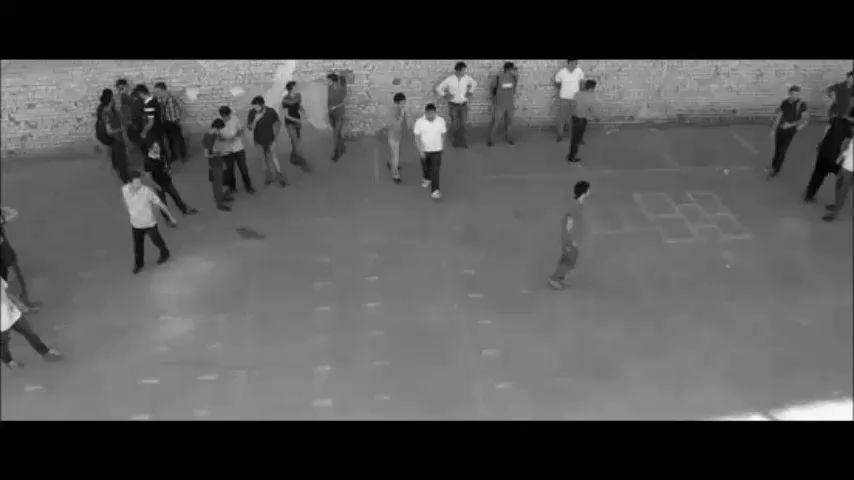

In [ ]:
# Visualizzazione di un frames di un campione normale.
frames_normal[0]

In [ ]:
frames_anomaly = load_data('/content/anomaly', 6) # Vengono presi 6 frames al secondo

Number of frames: 1594


array([[2, 2, 2, ..., 0, 0, 0],
       [2, 2, 2, ..., 0, 0, 0],
       [2, 2, 2, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)
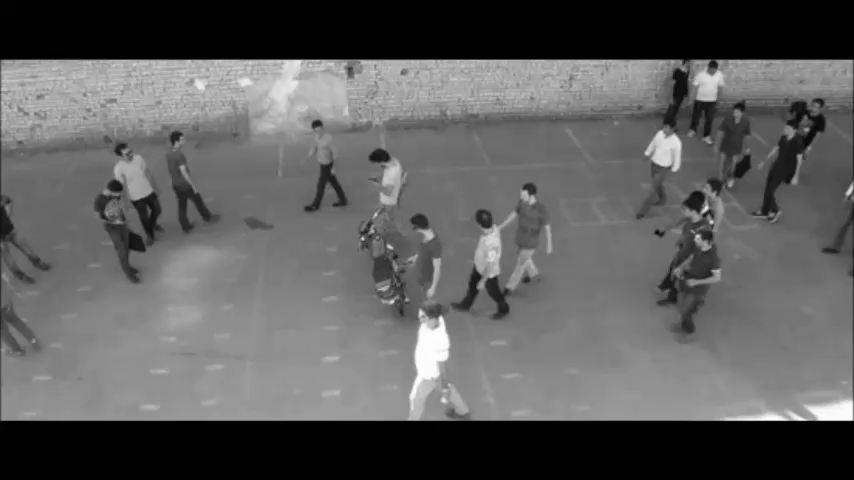

In [ ]:
# Visualizzazione di un frames di un campione anomaly.
frames_anomaly[0]

##1.5 - Funzione per estrazione delle features

In [ ]:
#funzione per la barra di avanzamento
def progress(value, max=100):
    return HTML("""<progress value='{value}' max='{max}' style='width: 100%'>
            {value}
        </progress>""".format(value=value, max=max))

#funzione per l'estrazione delle features
def extract_features_chunked(frames, chunk_size=100, output_file=None):
    print('Extracting Optical Flow and additional features from frames...')
    out = display(progress(0, len(frames)), display_id=True)
    kk = 0
    all_features = []

    if output_file is not None:
        h5f = h5py.File(output_file, 'w')  # Apre il file solo se output_file non è None
        dset = None


    for start in range(0, len(frames) - 1, chunk_size):
        end = min(start + chunk_size, len(frames) - 1)
        chunk_features = []

        for i in range(start, end):
            frame1 = frames[i]
            frame2 = frames[i + 1]

            # Calculate optical flow with Farneback method
            flow = cv2.calcOpticalFlowFarneback(frame1, frame2, None, 0.5, 3, 15, 3, 5, 1.2, 0)

            # Calculate magnitude and angle of the flow
            mag, ang = cv2.cartToPolar(flow[..., 0], flow[..., 1])

            # Calculate features:
            mean_mag = np.mean(mag)
            std_mag = np.std(mag)
            median_ang = np.median(ang)

            # Aggregate features into a single array
            frame_features = np.array([mean_mag, std_mag, median_ang])

            # Flatten the flow and combine it with other features
            chunk_features.append(np.concatenate([flow.reshape(-1), frame_features]))

            kk += 1
            out.update(progress(kk, len(frames)))

        # Convert chunk features to a numpy array
        chunk_features = np.array(chunk_features)
        all_features.append(chunk_features)


        # Save chunk features to the HDF5 file if available
        if output_file is not None:
            if dset is None:
                dset = h5f.create_dataset('features', data=chunk_features, maxshape=(None, chunk_features.shape[1]), chunks=True)
            else:
                dset.resize(dset.shape[0] + chunk_features.shape[0], axis=0)
                dset[-chunk_features.shape[0]:] = chunk_features

        # Free memory by deleting chunk_features
        del chunk_features
    if output_file is not None:
      print(f"Features saved to {output_file}")
    return np.vstack(all_features)

##1.6 - Estrazione features *normal*

Estrazione delle features **senza** anomalie: viene specificato il path del file contenente le features.

Se questo è già stato creato viene caricato senza svolgere di nuovo l'estrazione, mentre se non esiste le features vengono estratte.

Se invece non si vogliono salvare le features in un file viene impostato il parametro _output_file_ a _None_.

In [ ]:
output_path = '/content/drive/MyDrive/AnomalyDetection/Features/features_combined_normal.h5'

if os.path.exists(output_path):
    print(f"Loading features from {output_path}")
    with h5py.File(output_path, 'r') as h5f:
        features_normal = h5f['features'][:]
else:
    print("Features file does not exist, extracting features...")

    # Se si vogliono estrarre le feature senza salvarle in memoria si setta output_file a None
    features_normal = extract_features_chunked(frames_normal, chunk_size=100, output_file=None)

print(f"Loaded features shape: {features_normal.shape}")

Features file does not exist, extracting features...
Extracting Optical Flow and additional features from frames...


##1.7 - Riduzione delle dimensionalità delle features *normal* con PCA

La riduzione delle dimensionalità delle features con PCA è una tecnica molto utilizzata nel pre-processing dei dati per diversi motivi fondamentali:

*   Riduzione del rumore;
*   Evitare l'overfitting;
*   Interpretazione dei dati;
*   Miglioramento dell'efficienza computazionale.



### 1.7.1 - Funzione per la riduzione delle dimensionalità delle features *normal* con PCA

In [ ]:
def reduce_dimensionality(features, n_components = 233):
  data = np.array(features)

  ipca = IncrementalPCA(n_components=n_components, batch_size=400)
  ipca.fit(data)
  reduced_data = ipca.transform(data)

  return reduced_data

reduced_data_normal = reduce_dimensionality(features_normal)

###1.7.2 - Rappresentazione della dimensione dell'array Numpy

In [ ]:
reduced_data_normal.shape

### 1.7.3 - Salvataggio features *normal* in caso di out della RAM

In [ ]:
#salvataggio feature in caso di out of RAM
with open('/content/drive/MyDrive/AnomalyDetection/Features/reduced_data.pkl', 'wb') as file:
    pickle.dump(reduced_data_normal, file)
#salviamo anche il modello per la successiva riduzione dei flussi del TEST set
# with open('/content/drive/MyDrive/AnomalyDetection/Features/ipca.pkl', 'wb') as file:
#     pickle.dump(ipca, file)

##1.8 - Estrazione features *anomaly*

Estrazione delle features **con** anomalie: viene specificato il path del file contenente le features.

Se questo è già stato creato viene caricato senza svolgere di nuovo l'estrazione, mentre se non esiste le features vengono estratte.

Se invece non si vogliono salvare le features in un file viene impostato il parametro *output_file* a *None*.

In [ ]:
output_path = '/content/drive/MyDrive/AnomalyDetection/Features/features_combined_anomaly.h5' #mettere il path in cui si vuole salvare il file

if os.path.exists(output_path):
    print(f"Loading features from {output_path}")
    with h5py.File(output_path, 'r') as h5f:
        features_anomaly = h5f['features'][:]
else:
    print("Features file does not exist, extracting features...")
    #se si vogliono estrarre le feature senza salvarle in memoria si setta output_file a None
    features_anomaly = extract_features_chunked(frames_anomaly, chunk_size=100, output_file=None)

print(f"Loaded features shape: {features_anomaly.shape}")


##1.9 - Riduzione delle dimensionalità delle features *anomaly* con PCA

###1.9.1 - Richiamo funzione per la riduzione delle dimensionalità delle features *anomaly* con PCA

In [ ]:
reduced_data_anomaly = reduce_dimensionality(features_anomaly)

###1.9.2 - Rappresentazione della dimensione dell'array Numpy

In [ ]:
reduced_data_anomaly.shape

###1.9.3 - Salvataggio delle features *anomaly* in caso di out della RAM

In [ ]:
#salvataggio feature in caso di out of RAM
with open('/content/drive/MyDrive/AnomalyDetection/Features/reduced_data_anomaly.pkl', 'wb') as file:
    pickle.dump(reduced_data_anomaly, file)

#salviamo anche il modello per la successiva riduzione dei flussi del TEST set
# with open('/content/drive/MyDrive/AnomalyDetection/Features/ipca_anomaly.pkl', 'wb') as file:
#     pickle.dump(ipca_anomaly, file)

##1.10 - Caricamento dei dati salvati dal Drive

###1.10.1 - Caricamento dei dati *normal*

In [ ]:
with open('/content/drive/MyDrive/AnomalyDetection/Features/reduced_data.pkl', 'rb') as file:
   reduced_data_normal = pickle.load(file)

###1.10.2 - Caricamento dei dati *anomaly*

In [ ]:
with open('/content/drive/MyDrive/AnomalyDetection/Features/reduced_data_anomaly.pkl', 'rb') as file:
   reduced_data_anomaly = pickle.load(file)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

#*FASE 2:* Implementazione dell'anomaly detector

##2.1 - Gaussian Mixture Model (GMM)

Il **GMM** è un modello statistico probabilistico che assume che tutti i dati campionati provengano da una combinazione di un numero finito di distribuzioni gaussiane con parametri ignoti.

GMM è particolarmente utile in applicazioni di clustering perché non solo assegna un punto dati di cluster più probabile, ma fornisce anche una probabilità di appartenenza a ciascun cluster, rendendolo una scelta eccellente per situazioni in cui i dati possono avere sovrapposizioni tra i cluster.

In [ ]:
# Array per conservare i valori di BIC e AIC
bics = []
aics = []
n_components_range = range(1, 11)  # Prova da 1 a 10 componenti

for n_components in n_components_range:
    gmm = GaussianMixture(n_components=n_components, covariance_type='full', random_state=42)
    gmm.fit(reduced_data_normal)
    bics.append(gmm.bic(reduced_data_normal))
    aics.append(gmm.aic(reduced_data_normal))

# Creazione dei grafici di BIC e AIC
plt.figure(figsize=(12, 6))
plt.plot(n_components_range, bics, label='BIC', marker='o')
plt.plot(n_components_range, aics, label='AIC', marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Information Criterion')
plt.legend()
plt.title('BIC and AIC for Different Number of Components')
plt.grid(True)
plt.show()

###2.1.1 - Lettura dei dati dal Drive

In [ ]:
import pickle
from sklearn.mixture import GaussianMixture
with open('/content/drive/MyDrive/AnomalyDetection/Features/reduced_data.pkl', 'rb') as file:
   reduced_data_normal = pickle.load(file)

###2.1.2 - Training del GMM

Scegliamo 3 facendo riferimento al grafico, il punto in cui le due funzioni iniziano ad allontanarsi è il punto che selezioniamo, in modo da evitare overfitting.

In [ ]:
gmm = GaussianMixture(n_components=3, random_state=0)
gmm.fit(reduced_data_normal)

###2.1.3 - Salvataggio modello su Drive

In [ ]:
with open('/content/drive/MyDrive/AnomalyDetection/Features/gmm.pkl', 'wb') as file:
    pickle.dump(gmm, file)

##2.2 - Calcolo degli score dei campioni di train *normal*

In [ ]:
with open('/content/drive/MyDrive/AnomalyDetection/Features/gmm.pkl', 'rb') as file:
   gmm = pickle.load(file)

scores_train = []

for d in reduced_data_normal:
  d = d.reshape(1,-1)
  score = gmm.score_samples(d)
  scores_train.append(score)

In [ ]:
print(np.mean(scores_train))
print(np.std(scores_train))

##2.3 - Stampa degli score GMM per frame

In [ ]:
import matplotlib.pyplot as plt
def plot_scores(scores):
    plt.figure(figsize=(10, 5))
    plt.plot(scores, marker='o', linestyle='-', color='b')
    plt.title('GMM Scores per Frame')
    plt.xlabel('Numero Frame')
    plt.ylabel('Score')
    plt.grid(True)
    plt.show()

plot_scores(scores_train)

##2.4 - Definizione della soglia *threshold*

In [ ]:
mean_score = np.mean(scores_train)
std_dev_score = np.std(scores_train)

# Definire una soglia; in questo esempio, 2 deviazioni standard sotto la media
threshold = mean_score - 8*(std_dev_score)

##2.5 - Calcolo degli score di test

In [ ]:
scores_test = []
#with open('/content/gmm.pkl', 'rb') as file:
#    gmm = pickle.load(file)
for d in reduced_data_anomaly:
  d = d.reshape(1,-1)
  score = gmm.score_samples(d)
  scores_test.append(score)

In [ ]:
print(np.mean(scores_test))
print(np.std(scores_test))
#threshold=np.mean(scores_test) - (2*(np.std(scores_test)))

## 2.6 - Rappresentazione degli score di test

In [ ]:
plot_scores(scores_test)

##2.7 - Valutazione e calcolo outliers

In [ ]:
# Identificare gli score anomali
anomalies = scores_test < threshold

# Visualizzare gli score e la soglia
plt.figure(figsize=(10, 5))
plt.plot(scores_test, label='GMM Scores')
plt.axhline(y=threshold, color='r', linestyle='--', label='Threshold')
plt.legend()
plt.title('GMM Scores with Anomaly Threshold')
plt.xlabel('Frame Index')
plt.ylabel('Score')
plt.show()

# Stampare gli indici dei frame anomali
anomalous_indices = np.where(anomalies)[0]
print("Anomalous frames at indices:", anomalous_indices)

##2.8 - Valutazione delle metriche

Creazione del vettore delle true labels e quello delle previsioni, che ci serviranno per fare le corrette valutazioni.

In [ ]:
num_anomalous_frames = len(reduced_data_anomaly)  # Numero di frame anomali
true_vector = np.ones(num_anomalous_frames, dtype=int)  # Tutti i frame sono anomali

# 'anomalous_indices' contiene gli indici dei frame che il modello GMM ha classificato come anomali
total_frames = max(max(anomalous_indices), num_anomalous_frames)   # Calcolo il numero totale dei frame considerati
predicted_vector = np.zeros(total_frames, dtype=int)  # Inizializzo tutti i frame come normali

for i in anomalous_indices:
  predicted_vector[anomalous_indices] = 1  # Segno come anomali i frame identificati dal GMM


In [ ]:
# Calcola TP, FP, TN, FN

def invert(a):
  return np.logical_not(a).astype(int)

true_positives = np.sum(predicted_vector & true_vector)
false_positives = np.sum(predicted_vector & invert(true_vector))
true_negatives = np.sum(invert(predicted_vector) & invert(true_vector))
false_negatives = np.sum(invert(predicted_vector) & true_vector)

accuracy = (true_positives + true_negatives) / total_frames
precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

# Stampa i risultati
print(f"Accuratezza: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1_score:.4f}")


In [ ]:
print(f"TP: {true_positives:.4f}")
print(f"FP: {false_positives:.4f}")
print(f"TN: {true_negatives:.4f}")
print(f"FN: {false_negatives:.4f}")

In [ ]:
import numpy as np
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Assumi che `predicted_probabilities` sia un array delle probabilità di anomalia per ogni frame
# Esempio: predicted_probabilities = model.predict_proba(data)[:, 1] se il modello supporta predict_proba

# Calcolare i tassi FPR, TPR, e i threshold
fpr, tpr, thresholds = roc_curve(true_vector, predicted_vector)

# Calcolare l'area sotto la curva (AUC)
roc_auc = auc(fpr, tpr)

# Visualizzare la Curva ROC
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


#*FASE 3:* Analisi dei risultati


##3.1 - Caricamento del video di prova

In [ ]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

downloaded = drive.CreateFile({'id': '1o4cCkeUCrV6-FY_y4ron8PEVbAngRfp0'})
downloaded.GetContentFile('video_prof_IAS.zip')
!unzip video_prof_IAS

print('Done! Run the BSIF Filters download code.')

##3.2 - Estrazione dei frames e visualizzazione

In [ ]:
frames_video_test = load_data("/content", 6) # Vengono presi 6 frames al secondo

In [ ]:
frames_video_test[0]

##3.3 - Estrazione delle features

In [ ]:
output_path = '/content/drive/MyDrive/AnomalyDetection/Features/features_video_test.h5'

if os.path.exists(output_path):
    print(f"Loading features from {output_path}")
    with h5py.File(output_path, 'r') as h5f:
        features_video_test = h5f['features'][:]
else:
    print("Features file does not exist, extracting features...")
    #se si vogliono estrarre le feature senza salvarle in memoria si setta output_file a None
    features_video_test = extract_features_chunked(frames_video_test, chunk_size=100, output_file=None)

print(f"Loaded features shape: {features_video_test.shape}")

Andiamo a concatenare le features appena estratte per permettere al modello statistico GMM di avere abbastanza dati in ingresso.

In [ ]:
features2=np.concatenate((features_video_test,features_video_test), axis=0)
features2.shape

Andiamo a ridurre le dimensionalità delle features appena concatenate. Se sono già presenti nel drive vengono caricate, altrimenti viene ridotta la dimensionalità

In [ ]:
reduced_data_path = '/content/drive/MyDrive/AnomalyDetection/Features/reduced_data_test.pkl'

if os.path.exists(reduced_data_path):
  print(f"Loading data from {output_path}")
  with open(reduced_data_path, 'rb') as file:
   reduced_data_test = pickle.load(file)
else:
  print("Data file does not exist, reducing dimensionality")
  reduced_data_test = reduce_dimensionality(features_video_test)
  #salvataggio feature in caso di out of RAM
  with open('/content/drive/MyDrive/AnomalyDetection/Features/reduced_data_test.pkl', 'wb') as file:
    pickle.dump(reduced_data_test, file)

In [ ]:
reduced_data_test.shape

In [ ]:
reduced_data_test = reduced_data_test[:,:233]

##3.4 - Calcolo degli score

In [ ]:
scores_video_test = []
#with open('/content/gmm.pkl', 'rb') as file:
#    gmm = pickle.load(file)
for d in reduced_data_test:
  d = d.reshape(1,-1)
  score = gmm.score_samples(d)
  scores_video_test.append(score)

In [ ]:
# mean_score = np.mean(scores_video)
# std_dev_score = np.std(scores_video)

# # Definire una soglia; in questo esempio, 2 deviazioni standard sotto la media
# threshold = mean_score - std_dev_score

##3.5 - Creazione del vettore di ground truth

*Creazione del vettore di ground truth:* i valori dei frame senza anomalia sono stati impostati manualmente a 0 e quelli con anomalie sono stati impostati manualmente a 1.

Il labeling è stato fatto per testare la precisione del modello statistico.

In [ ]:
true_vector_video = np.zeros(len(features2), dtype = int)
true_vector_video[155:233] = 1
true_vector_video[387:465] = 1

##3.6 - Idenficazione delle anomalie e visualizzazione

In [ ]:
# Identificare gli score anomali
anomalies = scores_video_test < threshold

# Visualizzare gli score e la soglia
plt.figure(figsize=(10, 5))
plt.plot(scores_video_test, label='GMM Scores')
plt.axhline(y=threshold, color='r', linestyle='--', label='Threshold')
plt.legend()
plt.title('GMM Scores with Anomaly Threshold')
plt.xlabel('Frame Index')
plt.ylabel('Score')
plt.show()

# Stampare gli indici dei frame anomali
anomalous_indices = np.where(anomalies)[0]
print("Anomalous frames at indices:", anomalous_indices)

##3.7 - Visualizzazione degli indici reali con anomalie

In [ ]:
anomalous_frame_indices = [i for i, is_anomalous in enumerate(true_vector_video) if is_anomalous]
print(anomalous_frame_indices)

##3.8 - Computazione del vettore anomalia predetto dal modello

In [ ]:
total_frames_test = len(scores_video_test) # Calcolo il numero totale dei frame considerati
predicted_vector = np.zeros(total_frames_test, dtype=int)  # Inizializzo tutti i frame come normali

# 'anomalous_indices_test' contiene gli indici dei frame che il modello GMM ha classificato come anomali
predicted_vector[anomalous_indices] = 1  # Segno come anomali i frame identificati dal GMM

##3.9 - Valutazione del modello

In [ ]:
# Calcola TP, FP, TN, FN

def invert(a):
  return np.logical_not(a).astype(int)

true_positives = np.sum(predicted_vector & true_vector_video)
false_positives = np.sum(predicted_vector & invert(true_vector_video))
true_negatives = np.sum(invert(predicted_vector) & invert(true_vector_video))
false_negatives = np.sum(invert(predicted_vector) & true_vector_video)

accuracy = (true_positives + true_negatives) / total_frames_test
precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

# Stampa i risultati
print(f"Accuratezza: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1_score:.4f}")

In [ ]:
print(f"TP: {true_positives:.4f}")
print(f"FP: {false_positives:.4f}")
print(f"TN: {true_negatives:.4f}")
print(f"FN: {false_negatives:.4f}")

In [ ]:
# Normalize scores to be between 0 and 1
scores_min = np.min(scores_video_test)
scores_max = np.max(scores_video_test)
normalized_scores = (scores_video_test - scores_min) / (scores_max - scores_min)

# Define the ground truth vector as previously done
true_vector_video = np.zeros(len(scores_video_test), dtype=int)
true_vector_video[155:233] = 1
true_vector_video[387:465] = 1

# Calculate ROC curve and AUC using the normalized scores
fpr, tpr, thresholds = roc_curve(true_vector_video, normalized_scores)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [ ]:
# Normalizziamo i punteggi di anomalia tra 0 e 1 se necessario
#probabilities = (scores_video_test - np.min(scores_video_test)) / (np.max(scores_video_test) - np.min(scores_video_test))

# Calcola la curva ROC e l'AUC
fpr, tpr, thresholds = roc_curve(true_vector_video, predicted_vector)
roc_auc = auc(fpr, tpr)

# Traccia la curva ROC
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# *FASE 4:* Prova su un video mai visto

##4.1 - Estrazione dei frames e visualizzazione

In [ ]:
frames_video_youtube = load_data("/content/youtube",6) # Vengono presi 6 frames al secondo

In [ ]:
frames_video_youtube[0]

##4.2 - Estrazione delle features

In [ ]:
output_path = '/content/drive/MyDrive/AnomalyDetection/Features/features_video_youtube.h5'

if os.path.exists(output_path):
    print(f"Loading features from {output_path}")
    with h5py.File(output_path, 'r') as h5f:
        features_video_youtube = h5f['features'][:]
else:
    print("Features file does not exist, extracting features...")
    #se si vogliono estrarre le feature senza salvarle in memoria si setta output_file a None
    features_video_youtube = extract_features_chunked(frames_video_youtube, chunk_size=100, output_file=None)

print(f"Loaded features shape: {features_video_youtube.shape}")

## 4.3 - Riduzione della dimensionalità

In [ ]:
reduced_data_path = '/content/drive/MyDrive/AnomalyDetection/Features/reduced_data_youtube.pkl'

if os.path.exists(reduced_data_path):
  print(f"Loading data from {output_path}")
  with open(reduced_data_path, 'rb') as file:
   reduced_data_youtube = pickle.load(file)
else:
  print("Data file does not exist, reducing dimensionality")
  reduced_data_youtube = reduce_dimensionality(features_video_youtube)
  #salvataggio feature in caso di out of RAM
  with open('/content/drive/MyDrive/AnomalyDetection/Features/reduced_data_youtube.pkl', 'wb') as file:
    pickle.dump(reduced_data_youtube, file)

In [ ]:
reduced_data_youtube.shape

## 4.4 - Calcolo degli scores

In [ ]:
scores_video_youtube = []
#with open('/content/gmm.pkl', 'rb') as file:
#    gmm = pickle.load(file)
for d in reduced_data_youtube:
  d = d.reshape(1,-1)
  score = gmm.score_samples(d)
  scores_video_youtube.append(score)

## 4.5 - Identificazione delle anomalie e visualizzazione

In [ ]:
# Identificare gli score anomali
anomalies = scores_video_youtube < threshold

# Visualizzare gli score e la soglia
plt.figure(figsize=(10, 5))
plt.plot(scores_video_youtube, label='GMM Scores')
plt.axhline(y=threshold, color='r', linestyle='--', label='Threshold')
plt.legend()
plt.title('GMM Scores with Anomaly Threshold')
plt.xlabel('Frame Index')
plt.ylabel('Score')
plt.show()

# Stampare gli indici dei frame anomali
anomalous_indices = np.where(anomalies)[0]
print("Anomalous frames at indices:", anomalous_indices)